# Search for similar audio clips with FAISS using BirdNET feature embeddings

In this notebook, we demonstrate how we performed embedding query to find segments of our test audio most similar to pre-selected templates. Here, we:

1. Create FAISS index files from embedding files generated in a prior notebook.
2. Query the created index files to find embeddings closest to embeddings from our template clips.

Note that here we use a tiny subset of the data used for our study.

## Setup

In [1]:
# Import required packages

import os
import faiss
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
from time import time
from opensoundscape import Audio, Spectrogram
import IPython.display as ipd

In [2]:
# Set up required project directories and parameters

# Folder with sample embedding .CSV files (assume a flat folder with 3 files)
PROJECT_ROOT = 'sample_embeddings'

# Folder with template .CSV files
TEMPLATE_DIR = 'sample_templates'

# Folder for output distances
OUTPUT_DIR = 'sample_scores/embedding_search'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Desired audio sample rate
SAMPLE_RATE = 22050
# The embeddings size
EMB_DIM = 1023 

audio_len = 60   # Duration of a full test audio file, in seconds
clip_len = 3    # The duration of each template clip, in seconds

## Build FAISS index from feature embeddings

In [3]:
def build_index_from_embeddings(embedding_folder):
    """
    Create FAISS index to use for measuring the Euclidian (L2) distance between 
    our query vectors and vectors in the index.
    
    Parameters:
        embedding folder (str): Directory containing .CSV embedding files.
        
    Returns:
        index (faiss.IndexFlatL2): The FAISS index generated from embeddings from our test data.
        summary_df (pd.DataFrame): Summary mapping names of our files within the index.
        
    """
    # Find all CSV files in the embedding folder
    embedding_files = glob(os.path.join(embedding_folder, '*.csv'))
    print(len(embedding_files), "embedding files found.")
    
    embeddings_list = []
    file_names = []
    lengths = []
    audio_files = []
    
    # Loop over each CSV file.
    for file in embedding_files:
        df = pd.read_csv(file)
        # Extract embedding vectors from .CSV files
        # We skip the first 3 columns from our files as those are our "file", "start_time", and "end_time"
        emb = df.values[:, 3:].astype(np.float32)
        embeddings_list.append(emb)
        file_names.append(os.path.basename(file))
        lengths.append(df.shape[0])
        # Each CSV has a column 'file' that records the original audio file.
        # If it happens not to, use the CSV file's parent name.
        af = df['file'].iloc[0] if 'file' in df.columns else os.path.basename(file)
        audio_files.append(af)
    
    # Concatenate embeddings into one big matrix
    all_embeddings = np.vstack(embeddings_list)
    d = all_embeddings.shape[1]
    print("Embedding dimension is:", d)
    
    # Build a FAISS index (L2 distance)
    index = faiss.IndexFlatL2(d)
    index.add(all_embeddings)
    print("Total embeddings in index:", index.ntotal)
    
    summary_df = pd.DataFrame({
        'embedding_file': file_names,
        'audio_file': audio_files,
        'len': lengths
    })
    summary_df['cumulative_len'] = summary_df['len'].cumsum()
    
    return index, summary_df

In [4]:
# Build the index
index, summary_df = build_index_from_embeddings(PROJECT_ROOT)

3 embedding files found.
Embedding dimension is: 1024
Total embeddings in index: 60


## Helper functions to later process outputs

In [5]:
def map_positions_to_audio(df_csv, positions):
    """
    Map arbitrary positions (returned by FAISS) to audio file names using cumulative lengths.
    """
    cumulative_lengths = df_csv['cumulative_len'].to_numpy()
    audio_files = df_csv['audio_file'].to_numpy()
    indices = np.searchsorted(cumulative_lengths, positions, side='left')
    # (Indices may be out-of-bound if the position exceeds; here we assume positions are valid)
    return audio_files[indices]

In [6]:
def make_df(flat_list, distance, position, query_name):
    """
    Build a DataFrame of search results.
    
    The clip is computed as the remainder after dividing the position by (audio_len/clip_len)
    (this maps to one of the sub-clips of the full audio).
    """
    clips = np.array(position) - ((np.array(position) // (audio_len // clip_len)) * (audio_len // clip_len)) + 1
    return pd.DataFrame({
        'file': flat_list,
        'query': query_name, 
        'position': position, 
        'start_time': clips*3, 
        'distance': distance
    })

In [11]:
def min_dist_wav(emb_df):
    """
    For each audio file, select the row with the minimum distance (highest match).
    """
    emb_df['wav'] = emb_df['file'].str.split('/').str[-1]
    emb_df['min_score'] = emb_df.groupby('wav')['distance'].transform('min')
    return emb_df[emb_df['distance'] == emb_df['min_score']].drop_duplicates(
        subset=['distance', 'min_score'], keep='first')[['file', 'query', 'start_time', 'min_score']]

## Perform similarity search on index using template embeddings

In [12]:
def search_index(index, query_embedding, k=5):
    """
    Search the FAISS index for the k nearest neighbors to the query_embedding.
    """
    distances, indices = index.search(query_embedding.reshape(1, -1), k)
    return distances.flatten(), indices.flatten()

In [13]:
# Get the list of template embeddings (should be existing .CSV files)
template_files = glob(os.path.join(TEMPLATE_DIR, '*.csv'))
print(len(template_files), "template files found.")

6 template files found.


In [14]:
# For each template, search the index for the closest segments.
outputs = []

for temp_file in template_files:
    print("\nProcessing template:", temp_file)
    query_emb = pd.read_csv(temp_file).values[:,3:].astype(np.float32)
    distances, indices = search_index(index, query_emb, k=6)
    
    # Map FAISS result positions to audio file names using the summary mapping.
    audio_mapped = map_positions_to_audio(summary_df, indices)

    # Build a results DataFrame using the helper function.
    result_df = make_df(audio_mapped, distances, indices, Path(temp_file).stem)
    # Optionally, select the best match per audio file.
    result_df_min = min_dist_wav(result_df)
    
    # Save the results to OUTPUT_DIR.
    output_path = os.path.join(OUTPUT_DIR, f"results_{Path(temp_file).stem}.csv")
    result_df_min.to_csv(output_path, index=False)
    print("Results saved to", output_path)
    outputs.append(result_df_min)


Processing template: sample_templates/template_3.csv
Results saved to sample_scores/embedding_search/results_template_3.csv

Processing template: sample_templates/template_2.csv
Results saved to sample_scores/embedding_search/results_template_2.csv

Processing template: sample_templates/template_1.csv
Results saved to sample_scores/embedding_search/results_template_1.csv

Processing template: sample_templates/template_5.csv
Results saved to sample_scores/embedding_search/results_template_5.csv

Processing template: sample_templates/template_4.csv
Results saved to sample_scores/embedding_search/results_template_4.csv

Processing template: sample_templates/atelopus_varius_call.csv
Results saved to sample_scores/embedding_search/results_atelopus_varius_call.csv


## Review a few results

In [15]:
display_clip_duration = 3

def display_results(result_tuple, play_audio=True):
    """
    - Calculate and plot the spectrogram of the audio clip selected for review.
    - Report relevant information about the clip, including its RIBBIT score.
    - If desired, listen to the audio clip.
    """
    print(f"Displaying audio file: {result_tuple[0]} at {result_tuple[1]} seconds:")
    # Load in desired audio clip
    audio = Audio.from_file(result_tuple[0], 
                            offset=result_tuple[1], 
                            duration=display_clip_duration)
    # Display spectrogram from our audio clip
    Spectrogram.from_audio(
        audio,
        window_samples=256,
        overlap_fraction=.9
    ).bandpass(0,5000).plot()
    # Play audio! :)
    if play_audio:
        ipd.display(ipd.Audio(audio.samples,rate=audio.sample_rate,autoplay=False))
    print(f"This clip got a score of {result_tuple[2]}.\n\n")

Displaying audio file: sample_audio/test_dset_1.wav at 36 seconds:


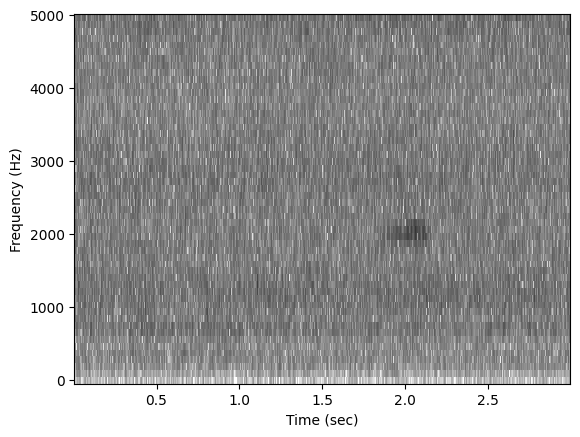

This clip got a score of 140.256591796875.


Displaying audio file: sample_audio/test_dset_3.wav at 9 seconds:


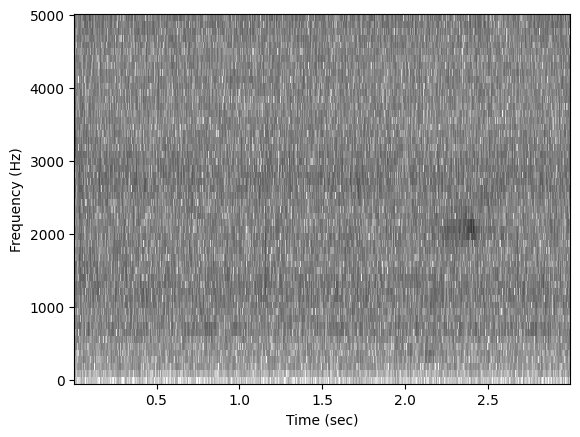

This clip got a score of 152.72787475585938.


Displaying audio file: sample_audio/test_dset_2.wav at 36 seconds:


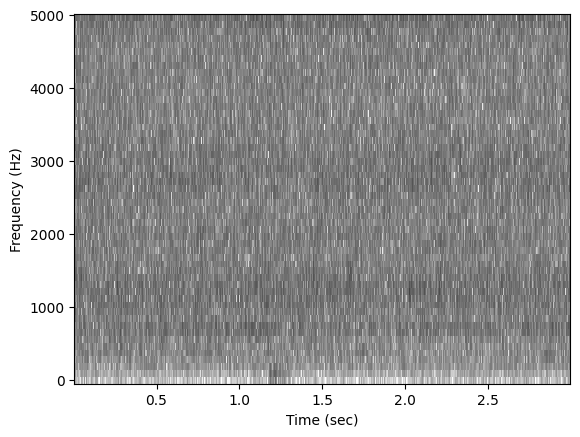

This clip got a score of 163.93231201171875.




In [19]:
"""Take a closer look at our last score DataFrame to display a desired 
number of highest-scoring clips from the latest file analyzed."""

# Set desired number of review clips.
n_review_clips = 3
# Subset DataFrame to that number of high-scoring clips.
clips_to_review = pd.concat(outputs).sort_values(
    by='min_score').drop_duplicates(
    ['file','start_time']).head(
    n_review_clips)
# Check out your results!
for i, row in clips_to_review.reset_index().iterrows():
    display_results(tuple(row[["file","start_time","min_score"]]), play_audio=True)